# SIRD Model

## Equations
* From https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIRD_model , without considering natural birth and death rate.

\begin{equation}
\begin{split}
\dot{S} &= -\frac{\beta I S}{N}\\
\dot{I} &= \frac{\beta I S}{N} - \gamma I - \mu I\\
\dot{R} & = \gamma I\\
\dot{D} & = \mu I
\end{split}
\end{equation}

## Variables
* $S$: Susceptible individuals
* $I$: Infected individuals
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+I+R+D$ Total population size (constant)

## Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

## Basic reproductive ratio
* From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7438206/
\begin{equation}
R_0 = \frac{\beta}{\gamma + \mu}
\end{equation}

# SIRD Simulation

## Libaries

In [56]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint

## SIRD Model

In [57]:
#Defining the differential equations
#Don't track S because all variables must add up to N

def SIRD(y, t, b, g, u, N): 
    dy=[0, 0, 0] # I, R, D
    S = N - sum(y);
    dy[0] = b*S*y[0]/N-(g+u)*y[0] # dI
    dy[1] = g*y[0] # dR
    dy[2] = u*y[0] # dD

    return dy

## Simulation with Given Parameters

In [58]:
# Define parameters and run ODE

# test for Kaohsiung
N = 3975803
b = 0.33 #beta
g = 0.22 #gamma
u = 0.0018 # mu

#Calculate basic reproductive ratio
R0 = b / (g + u)
print("R0 = {0:4.2f}".format(R0))

R0 = 1.49


## Plot
Plot on linear and log scale

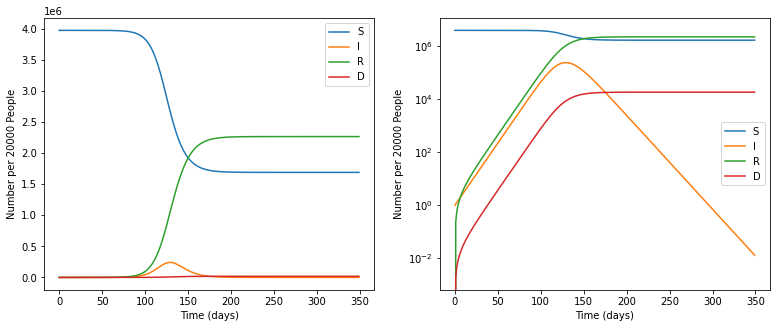

In [59]:
tmax = 350 # time length
tvec = np.arange(0, tmax, 1)
ic = np.zeros(3)
ic[0] = 1

soln = odeint(SIRD, ic, tvec, args=(b, g, u, N))
soln = np.hstack((N - np.sum(soln, axis=1, keepdims=True), soln))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(tvec, soln)
plt.xlabel("Time (days)")
plt.ylabel("Number per 20000 People")
plt.legend(("S", "I", "R", "D"))
# plt.ylim([0, 40000])

#Same plot but on log scale
plt.subplot(1, 2, 2)
plt.plot(tvec, soln)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 20000 People")
plt.legend(("S", "I", "R", "D"))
# plt.ylim([1, 200000])
#plt.tight_layout()

## Growth Rate

In [60]:
# get observed growth rate r (and doubling time) for a particular variable between selected time points
#(all infected classes eventually grow at same rate during early infection)

#Don't have a simple analytic formula for r for this model due to the complexity of the stages

def growth_rate(tvec, soln, t1, t2, i):
  i1 = np.where(tvec == t1)[0][0]
  i2 = np.where(tvec == t2)[0][0]
  r = (np.log(soln[i2, 1]) - np.log(soln[i1, 1])) / (t2 - t1)
  DoublingTime=np.log(2) / r

  return r, DoublingTime

In [61]:
(r, DoublingTime)=growth_rate(tvec, soln, 10, 20, 1)
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(r, DoublingTime))

The epidemic growth rate is = 0.11 per day and the doubling time  6.4 days 


# Estimate SIRD Model with Grid Search (Start from Here!!!)
* Reference: https://github.com/Lewuathe/COVID19-SIR/blob/master/solver.py

## Libaries

In [137]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd 

## SIRD Model

In [138]:
#Defining the differential equations
#Don't track S because all variables must add up to N

def SIRD(y, t, b, g, u, N): 
    dy=[0, 0, 0] # I, R, D
    S = N - sum(y);
    dy[0] = b*S*y[0]/N-(g+u)*y[0] # dI
    dy[1] = g*y[0] # dR
    dy[2] = u*y[0] # dD

    return dy

## Mean Square Error for I, R, and D

In [139]:
def MSE(timelineI, timelineR, timelineD, N, b, g, u):
    tmax = len(timelineI)
    tvec = np.arange(0, tmax, 1)
    ird = np.zeros(3)
    ird[0] = 1

    soln = odeint(SIRD, ird, tvec, args=(b, g, u, N)).transpose()

    lossI = np.sqrt(np.mean(np.power(soln[0] - timelineI, 2)))
    lossR = np.sqrt(np.mean(np.power(soln[1] - timelineR, 2)))
    lossD = np.sqrt(np.mean(np.power(soln[2] - timelineD, 2)))
    return lossI + lossR + lossD

## Search Parameters with Minimal MSE

In [172]:
def gridSearch(N, timelineI, timelineR, timelineD):
    minError = np.infty
    best_b, best_g, best_u = -1, -1, -1

    for b in np.arange(0.08, 0.5, 0.01):
        for g in np.arange(0.0, 0.3, 0.01):
            u = 0.0002     # fixed death rate
            error = MSE(timelineI, timelineR, timelineD, N, b, g, u)
            if error < minError:
                best_b, best_g, best_u = b, g, u
                minError = error

    return best_b, best_g, best_u


## Plot

Plot appromate/estimated I, R, and D on linear and log scale.

In [173]:
def plotEsti(timelineI, timelineR, timelineD, N, b, g, u, city):
    tvec = np.arange(0, len(timelineI), 1)
    soln = odeint(SIRD, np.array([1, 0, 0]), tvec, args=(b, g, u, N))

    solI = np.vstack((soln[:, 0], timelineI)).transpose()
    solR = np.vstack((soln[:, 1], timelineR)).transpose()
    solD = np.vstack((soln[:, 2], timelineD)).transpose()

    # I
    plt.figure(figsize=(10, 12))

    plt.subplot(3, 2, 1)
    plt.plot(tvec, solI)
    plt.xlabel("Time (days)")
    plt.ylabel("I")
    plt.legend(("pred", "real"))
    # plt.ylim([0,20000])

    # I but on log scale
    plt.subplot(3, 2, 2)
    plt.plot(tvec, solI)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("I")
    plt.legend(("estimation", "reality"))
    # plt.ylim([1,20000])

    plt.subplot(3, 2, 3)
    plt.plot(tvec, solR)
    plt.xlabel("Time (days)")
    plt.ylabel("R")
    plt.legend(("pred", "real"))
    # plt.ylim([0,20000])

    plt.subplot(3, 2, 4)
    plt.plot(tvec, solR)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("R")
    plt.legend(("estimation", "reality"))
    # plt.ylim([1,20000])

    plt.subplot(3, 2, 5)
    plt.plot(tvec, solD)
    plt.xlabel("Time (days)")
    plt.ylabel("D")
    plt.legend(("pred", "real"))
    # plt.ylim([0,20000])
    
    plt.subplot(3, 2, 6)
    plt.plot(tvec, solD)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("D")
    plt.legend(("pred", "real"))
    # plt.ylim([0,20000])

    plt.suptitle(f'Time-Series Prediction in {city}', y=0.9)

    plt.show()

Plot estimated and real new cases on linear and log scale.

In [174]:
def estiNew(soln):
    esti_new_infected = [soln[0][0]]
    for i in range(1, soln.shape[0]):
        delta_I = soln[i][0] - soln[i-1][0]
        delta_R = soln[i][1] - soln[i-1][1]
        delta_D = soln[i][2] - soln[i-1][2]

        esti_new_infected.append(delta_I + delta_R + delta_D)

    esti_new_infected = np.array(esti_new_infected).transpose()
    return esti_new_infected

In [175]:
def plotNewCases(new_infected_data, N, b, g, u, city):
    tvec = np.arange(0, len(new_infected_data), 1)
    soln = odeint(SIRD, np.array([1, 0, 0]), tvec, args=(b, g, u, N))

    soln = estiNew(soln)
    soln = np.vstack((soln, new_infected_data)).transpose()

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(tvec, soln)
    plt.xlabel("Time (days)")
    plt.ylabel("Number of New Cases")
    plt.legend(("estimation", "reality"))
    # plt.ylim([0,20000])

    #Same plot but on log scale
    plt.subplot(1, 2, 2)
    plt.plot(tvec, soln)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("Number of New Cases")
    plt.legend(("estimation", "reality"))
    # plt.ylim([1,20000])
    # plt.tight_layout()

    plt.suptitle(f'Time-Series Prediction in {city}')

    plt.show()

## Estimate for Cities

Get the approximate numbers of infected, recovered, and dead individuals respectively.


In [176]:
def getIRD(new_infected_data, new_dead_data):
    timelineI = []
    timelineR = []
    timelineD = []
    
    infected = 0
    dead = 0

    for i in range(len(new_infected_data)):
        infected += (new_infected_data[i] - new_dead_data[i])
        dead += new_dead_data[i]

        if i - 5 >= 0:
            recovered = int(new_infected_data[i-5] * 0.995)
        else:
            recovered = 0
        infected -= recovered

        timelineI.append(infected)
        timelineR.append(recovered)
        timelineD.append(dead)

    return timelineI, timelineR, timelineD


Get data for target city.

In [177]:
def getCityData(populationDf, confirmedDf, deadDf, city):
    # population: int
    # timeline: np.array([...])

    population = int(populationDf[populationDf['Region'] == city]['population'])

    confirmedCityDf = confirmedDf.loc[confirmedDf['city'] == city].asfreq('D')
    confirmedCityDf = confirmedCityDf[confirmedCityDf.index >= '2022-03-10']
    new_infected_data = confirmedCityDf.loc[:, 'count'].fillna(0).values

    deadCityDf = deadDf.loc[deadDf['city'] == city].asfreq('D')
    deadCityDf = deadCityDf[((deadCityDf.index >= '2022-03-10')
                            & (deadCityDf.index <= '2022-06-01'))]
    new_dead_data = deadCityDf.loc[:, 'death_new'].fillna(0).values

    timelineI, timelineR, timelineD = getIRD(new_infected_data, new_dead_data)

    return population, new_infected_data, timelineI, timelineR, timelineD

Estimate parameters for one city or Taiwan.

In [178]:
def estiCity(N, timelineI, timelineR, timelineD, city):
    # Kaohsiung data
    # new_infected_data = np.array([1,3,1,1,2,1,11,4,1,3,2,3,2,4,6,6,1,5,34,36,50,30,25,30,49,63,45,50,59,41,26,50,106,68,121,96,135,152,198,269,352,393,468,441,679,818,1042,1183,1782,2180,2076,1981,2069,3740,3326,3754,3886,3990,4341,5086,6967,6818,7788,7858,7451,7450,9774,9985,8809,11636,10023,9915,8616,10832,11728,10529])
    # N = 2700000    # city population
    b, g, u = gridSearch(N, timelineI, timelineR, timelineD)

    print(f"Best parameters: b = {b}, g = {g}, u = {u}")
    print(f"Minimal MSE = {MSE(timelineI, timelineR, timelineD, N, b, g, u)}")
    return b, g, u

Estimate for all cities.

===== City: KEE =====
population = 361612
Best parameters: b = 0.13999999999999996, g = 0.02, u = 0.0002
Minimal MSE = 4403.347028119518


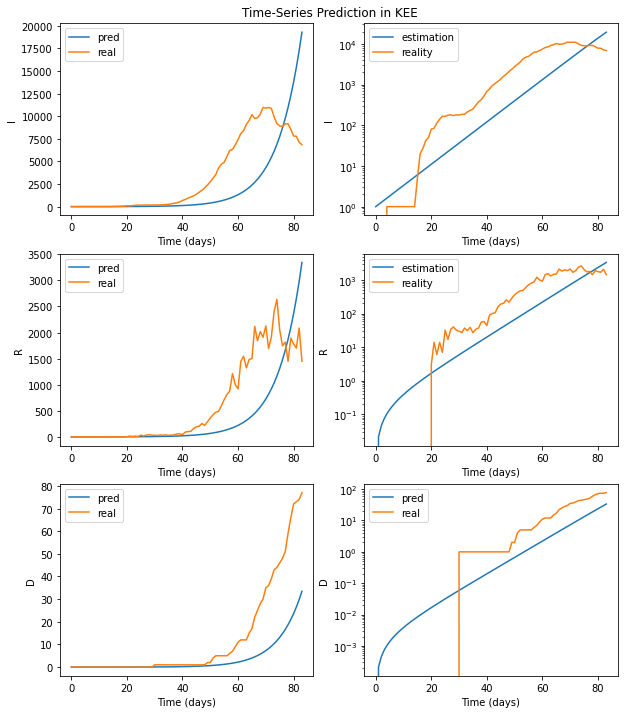

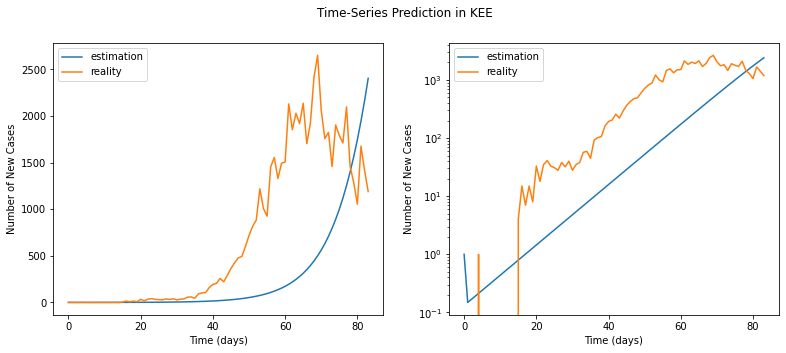

===== City: NWT =====
population = 3975803
Best parameters: b = 0.18999999999999995, g = 0.05, u = 0.0002
Minimal MSE = 53871.24058194476


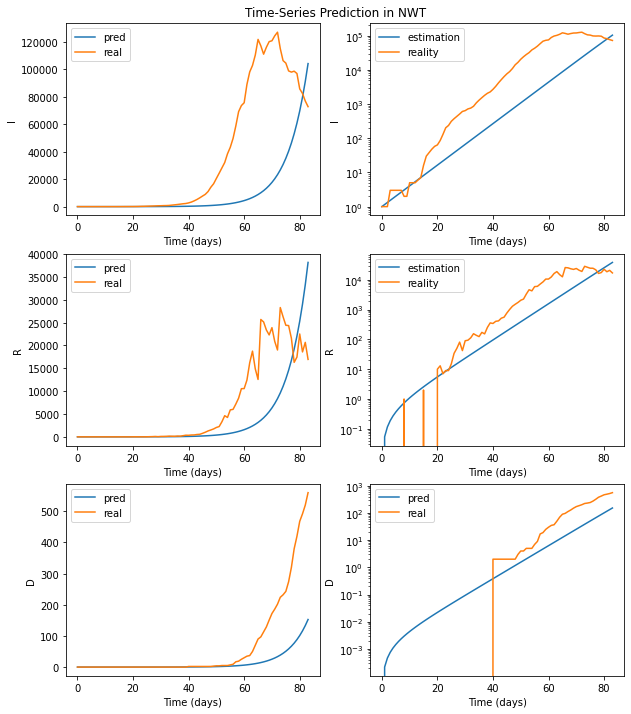

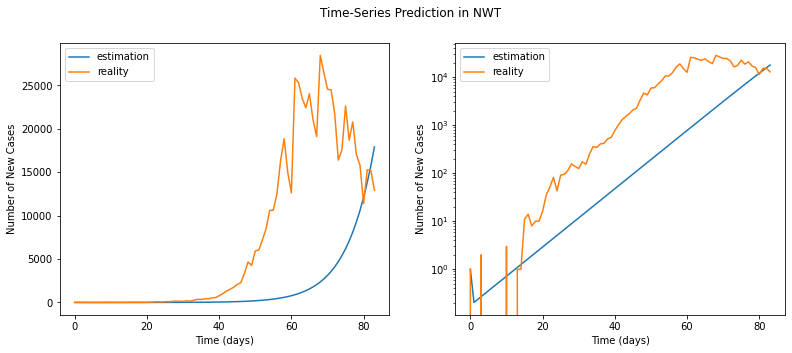

===== City: TPE =====
population = 2478124
Best parameters: b = 0.16999999999999996, g = 0.04, u = 0.0002
Minimal MSE = 22754.625093181778


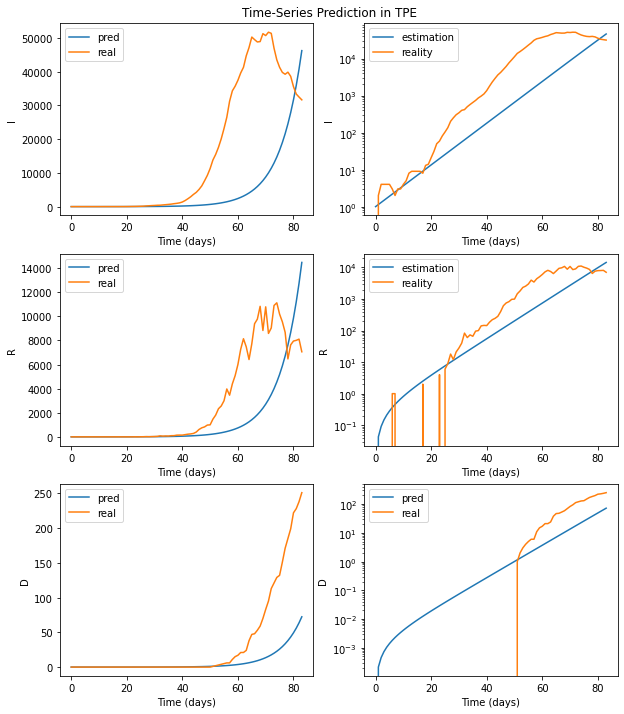

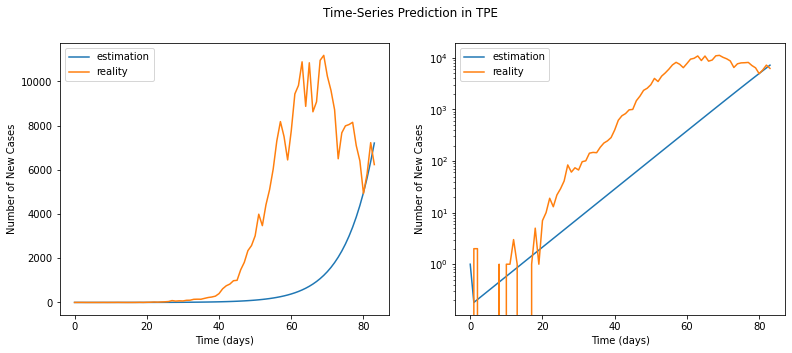

===== City: TAO =====
population = 2263430
Best parameters: b = 0.15999999999999998, g = 0.02, u = 0.0002
Minimal MSE = 21985.44771478585


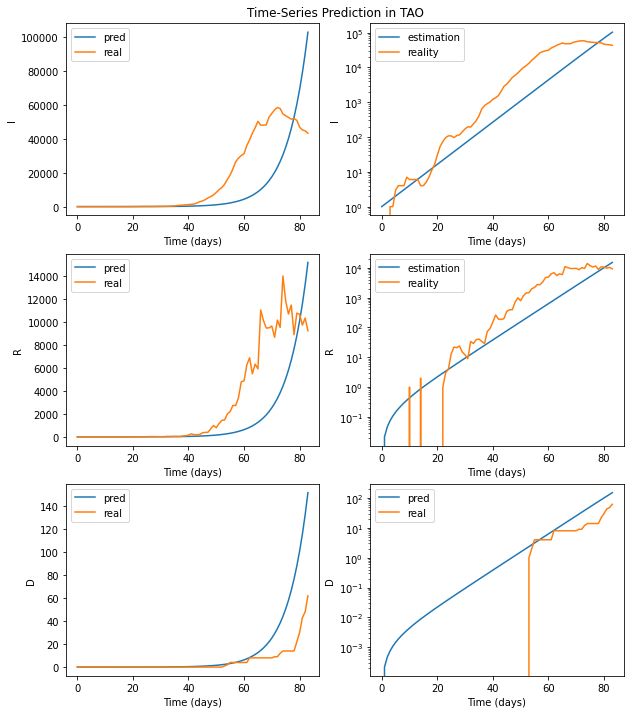

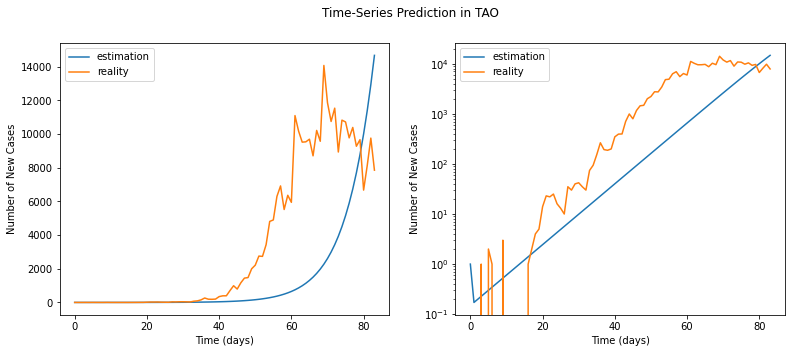

===== City: HSZ =====
population = 450494
Best parameters: b = 0.13999999999999996, g = 0.03, u = 0.0002
Minimal MSE = 2286.1450944906087


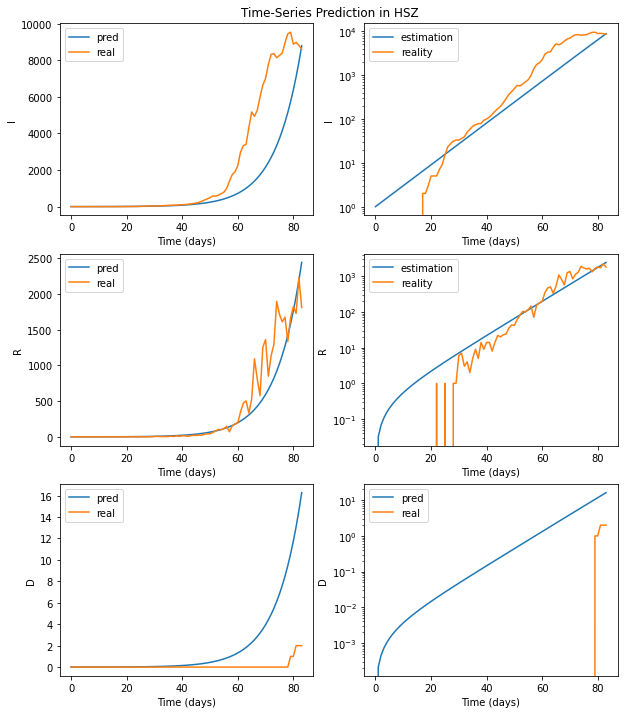

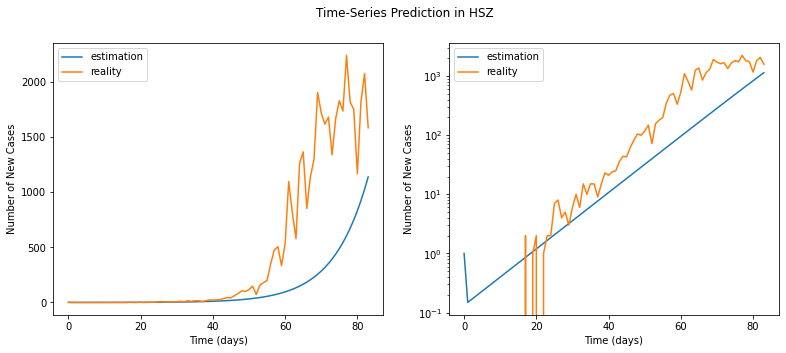

===== City: HSQ =====
population = 575682
Best parameters: b = 0.13999999999999996, g = 0.02, u = 0.0002
Minimal MSE = 3349.5905903871876


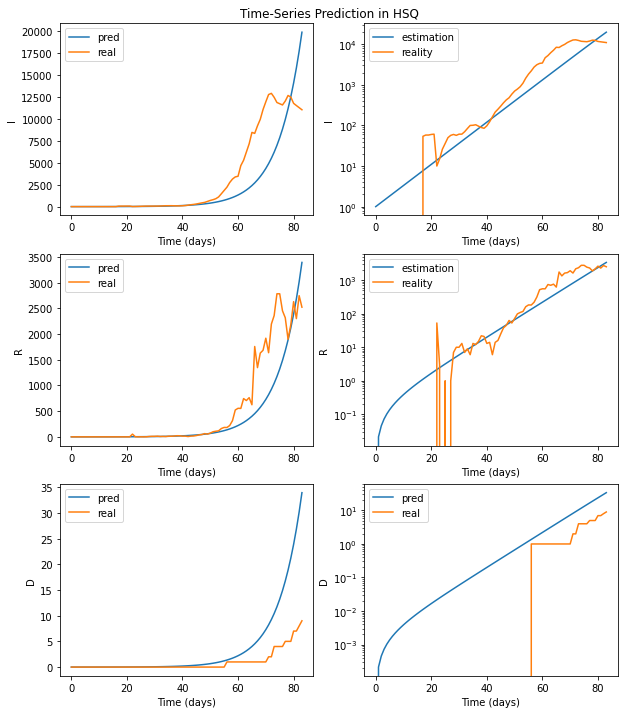

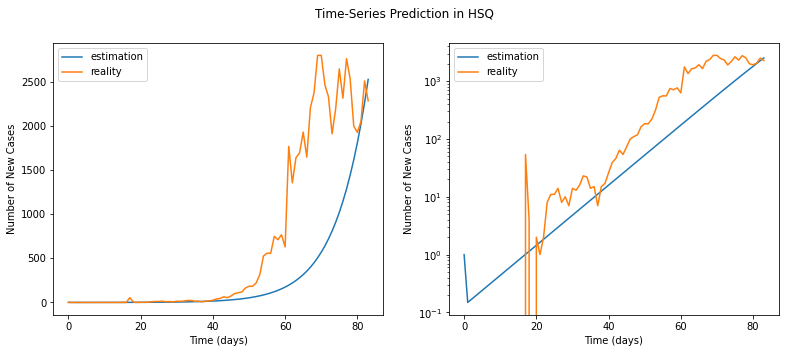

===== City: MIA =====
population = 535780
Best parameters: b = 0.13999999999999996, g = 0.03, u = 0.0002
Minimal MSE = 1809.229122678801


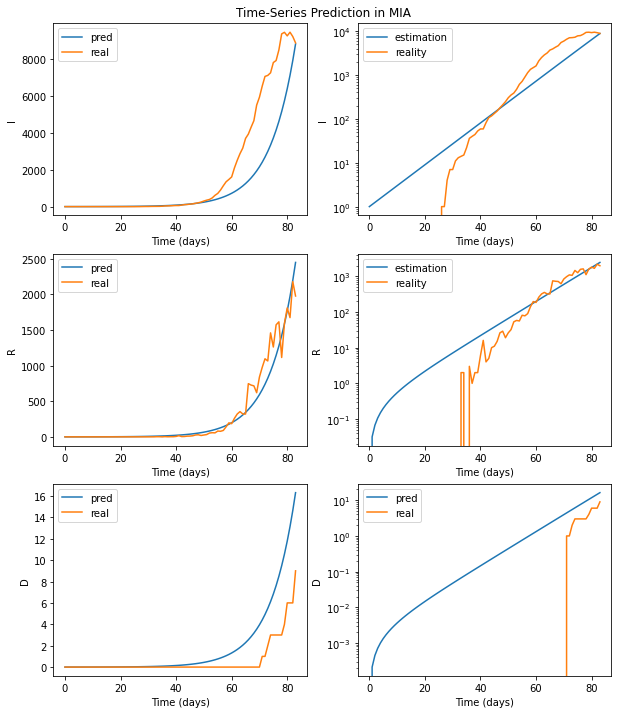

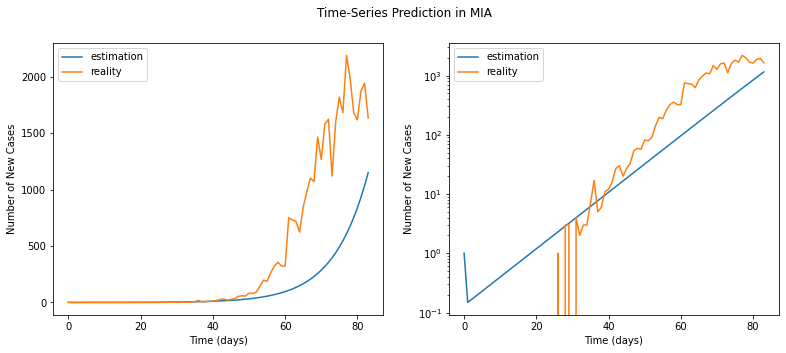

===== City: TXG =====
population = 2801069
Best parameters: b = 0.15999999999999998, g = 0.02, u = 0.0002
Minimal MSE = 11146.104074777491


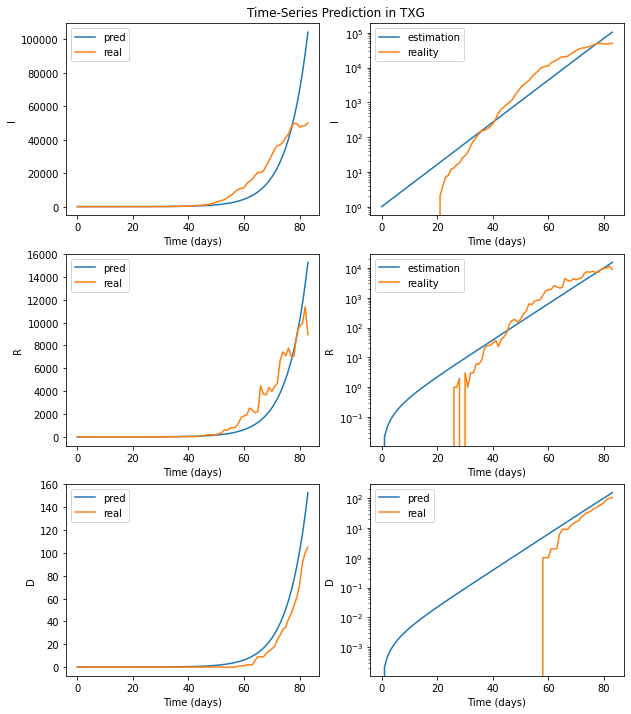

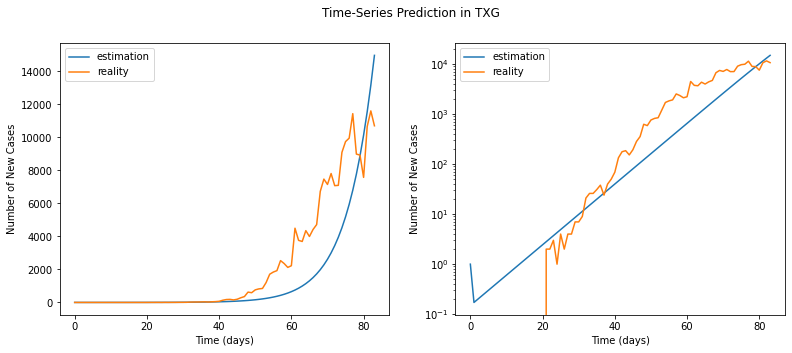

===== City: CHA =====
population = 1248262
Best parameters: b = 0.14999999999999997, g = 0.03, u = 0.0002
Minimal MSE = 2622.832186441952


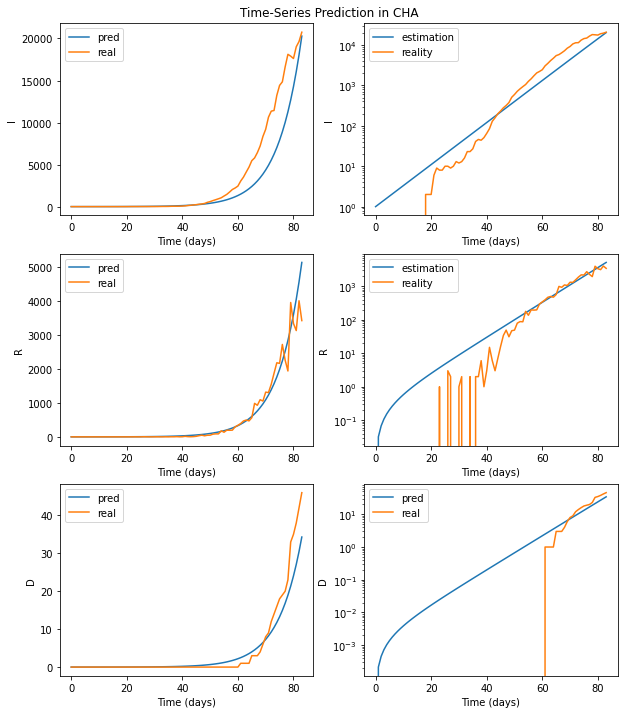

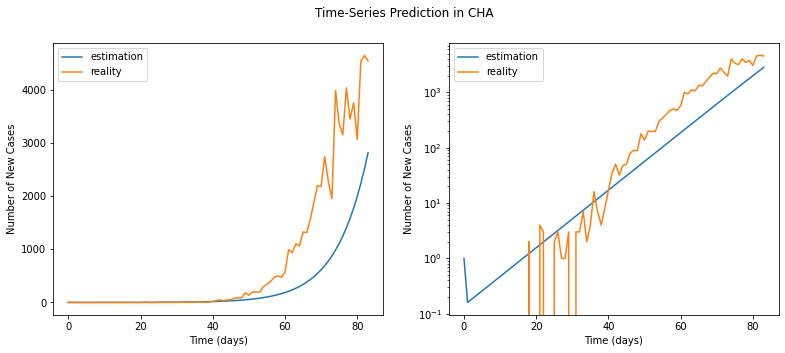

===== City: NAN =====
population = 481943
Best parameters: b = 0.12999999999999998, g = 0.02, u = 0.0002
Minimal MSE = 774.89101838058


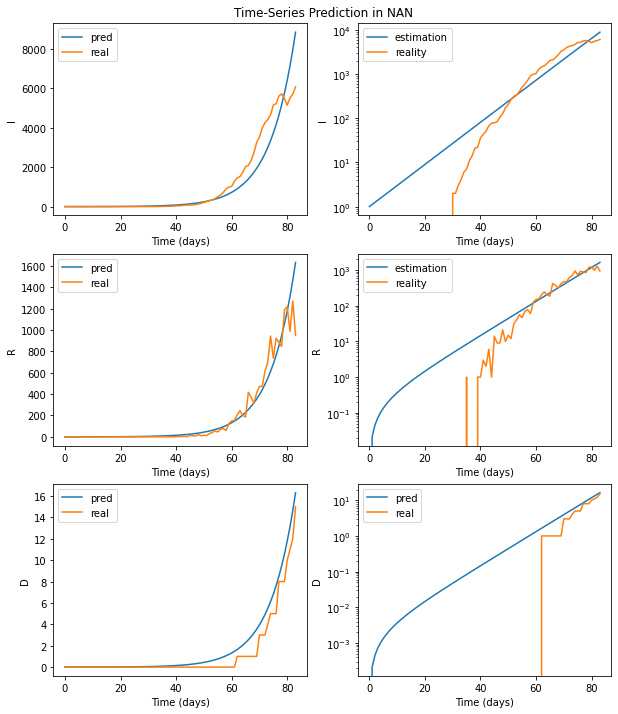

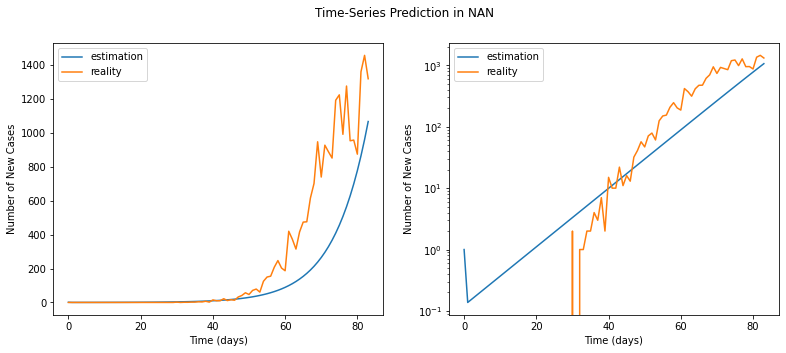

===== City: YUN =====
population = 666655
Best parameters: b = 0.12999999999999998, g = 0.02, u = 0.0002
Minimal MSE = 980.1628026782271


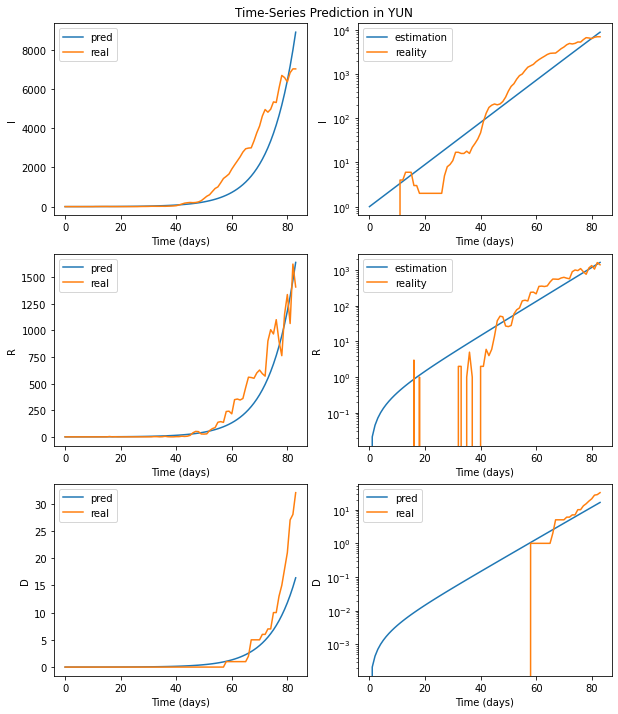

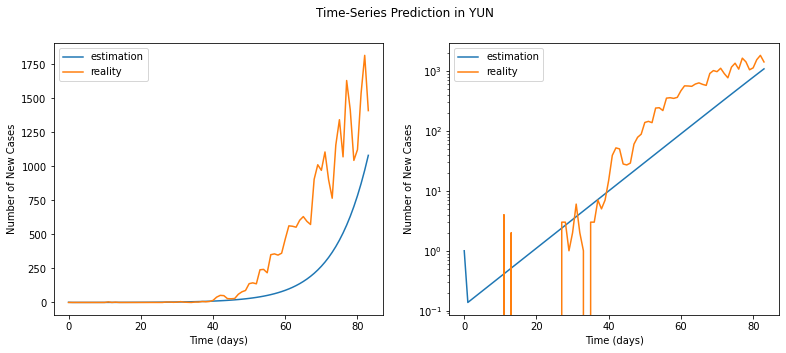

===== City: CYQ =====
population = 490824
Best parameters: b = 0.12999999999999998, g = 0.02, u = 0.0002
Minimal MSE = 764.86710493286


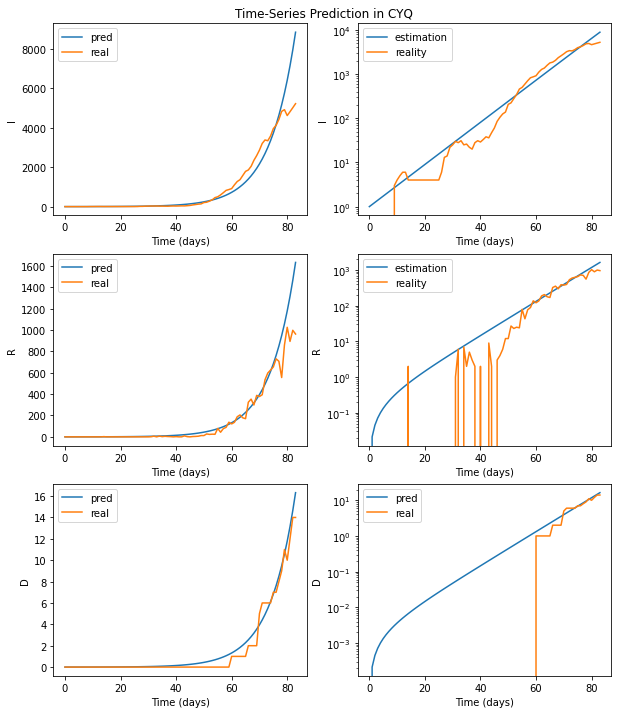

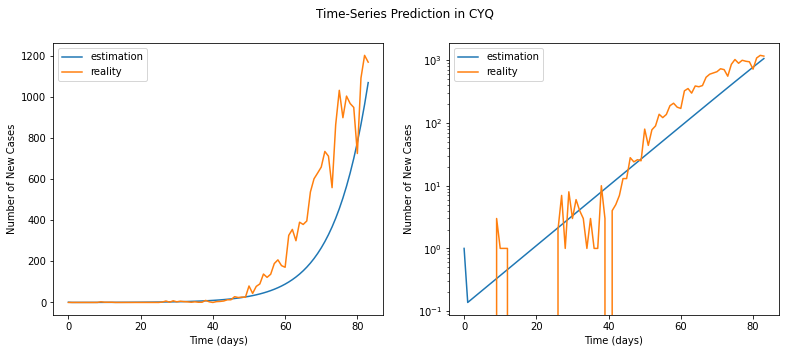

===== City: CYI =====
population = 263202
Best parameters: b = 0.11999999999999998, g = 0.02, u = 0.0002
Minimal MSE = 372.06867697615746


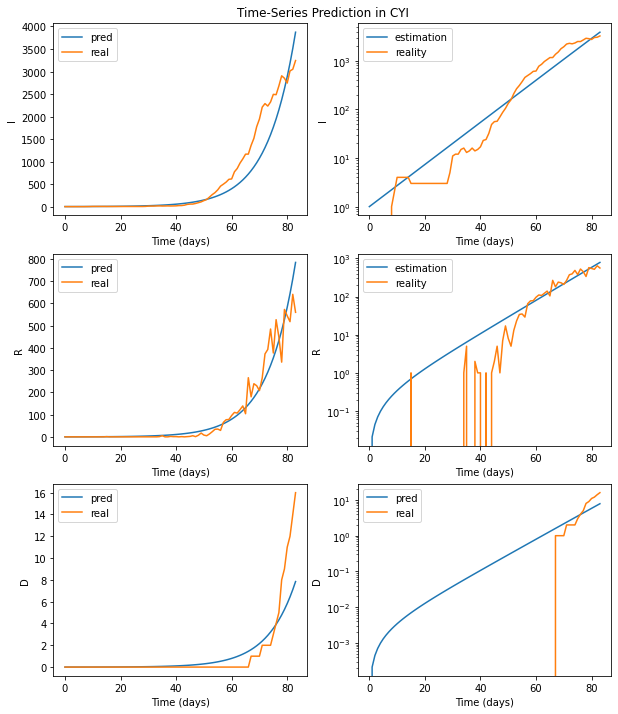

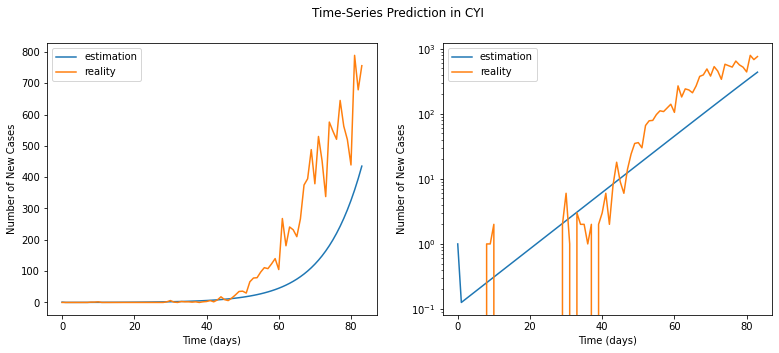

===== City: TNN =====
population = 1852429
Best parameters: b = 0.14999999999999997, g = 0.02, u = 0.0002
Minimal MSE = 4851.347842709585


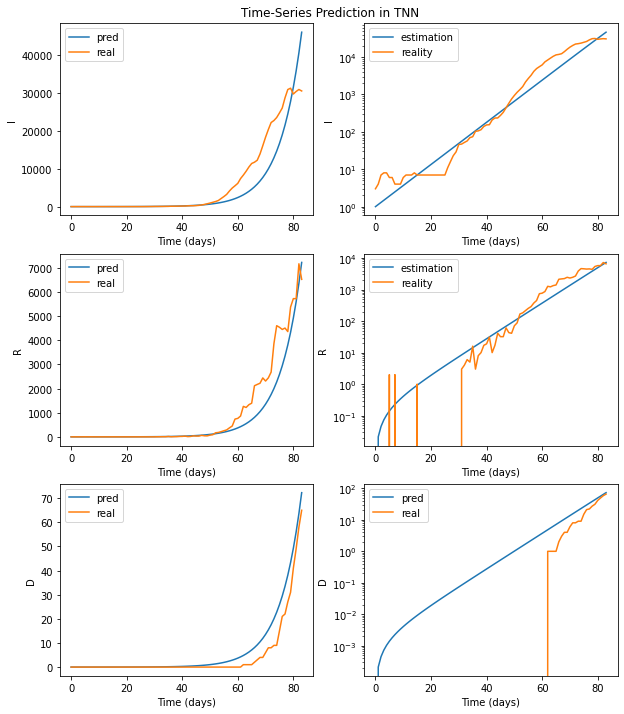

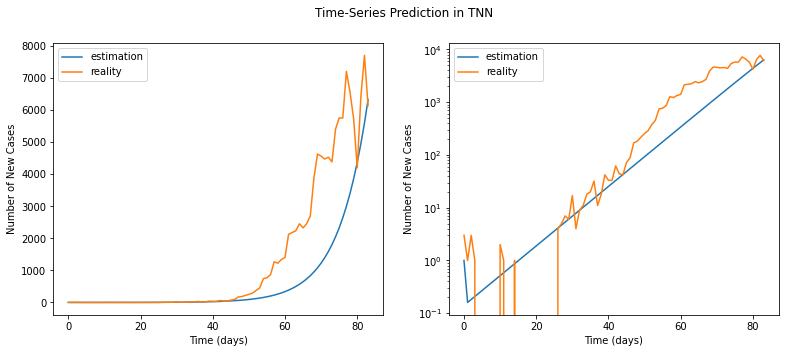

===== City: KHH =====
population = 2726087
Best parameters: b = 0.15999999999999998, g = 0.02, u = 0.0002
Minimal MSE = 10407.66449470998


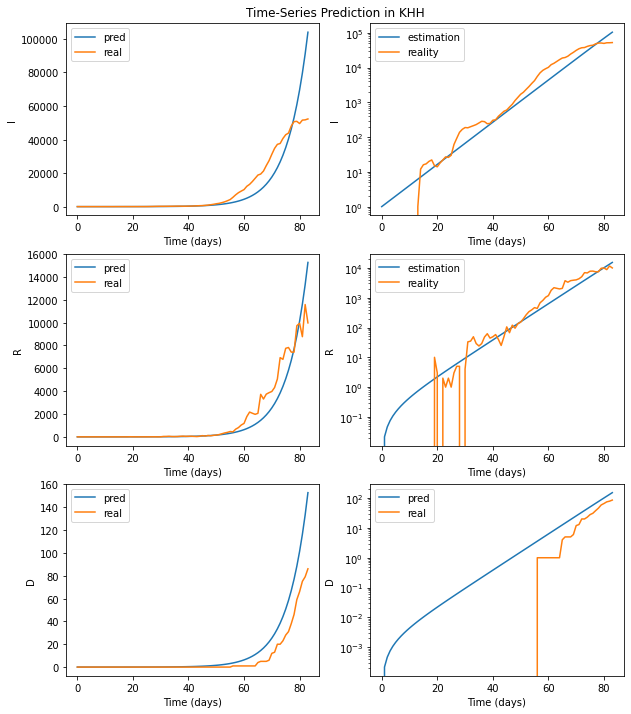

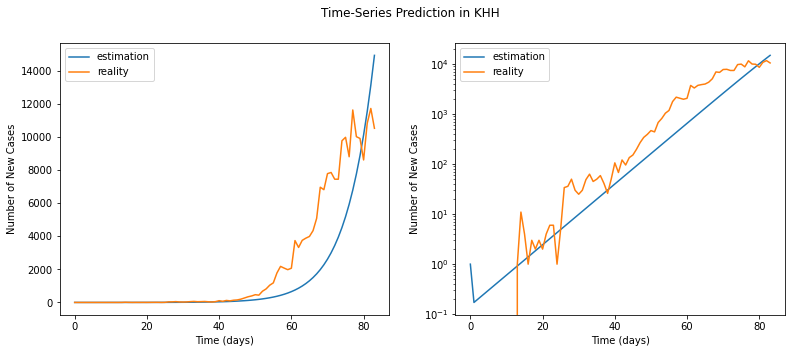

===== City: PIF =====
population = 801377
Best parameters: b = 0.13999999999999996, g = 0.02, u = 0.0002
Minimal MSE = 2180.3393725436063


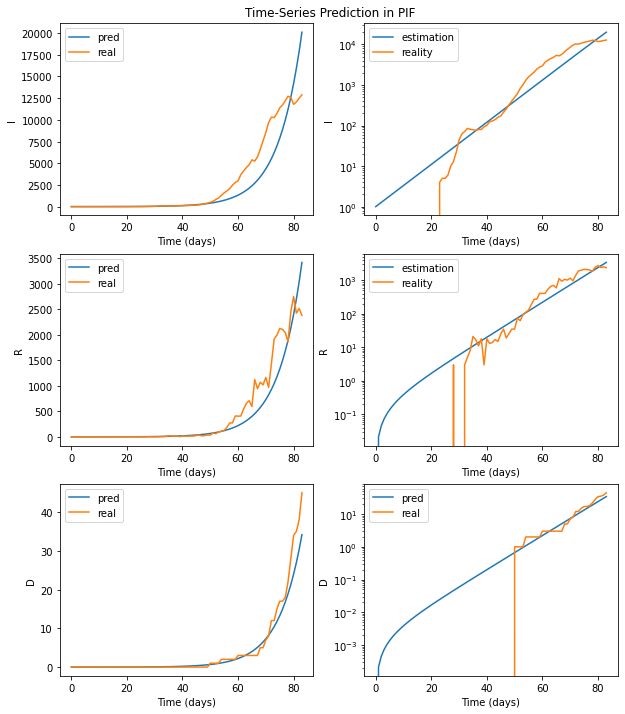

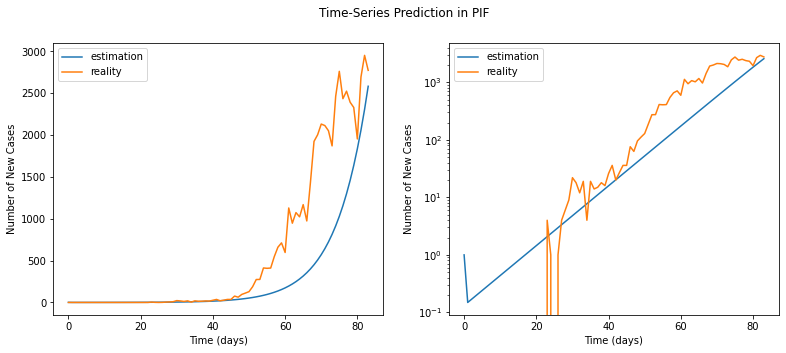

===== City: ILA =====
population = 448963
Best parameters: b = 0.13999999999999996, g = 0.02, u = 0.0002
Minimal MSE = 3168.474969827646


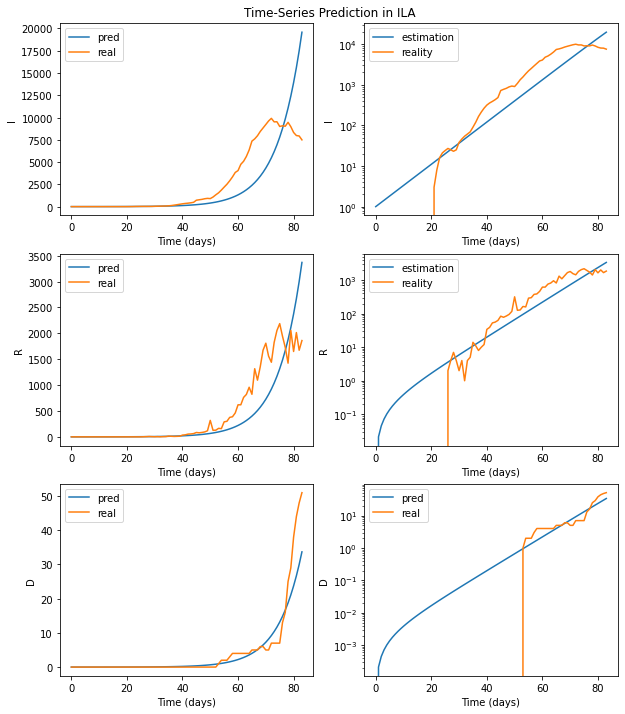

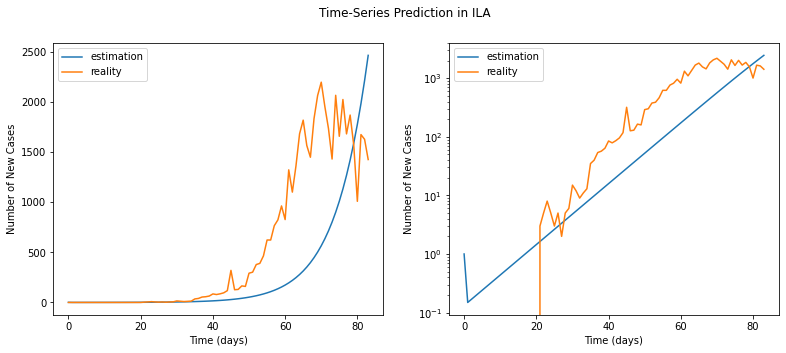

===== City: HUA =====
population = 319842
Best parameters: b = 0.13999999999999996, g = 0.03, u = 0.0002
Minimal MSE = 1927.5265312268752


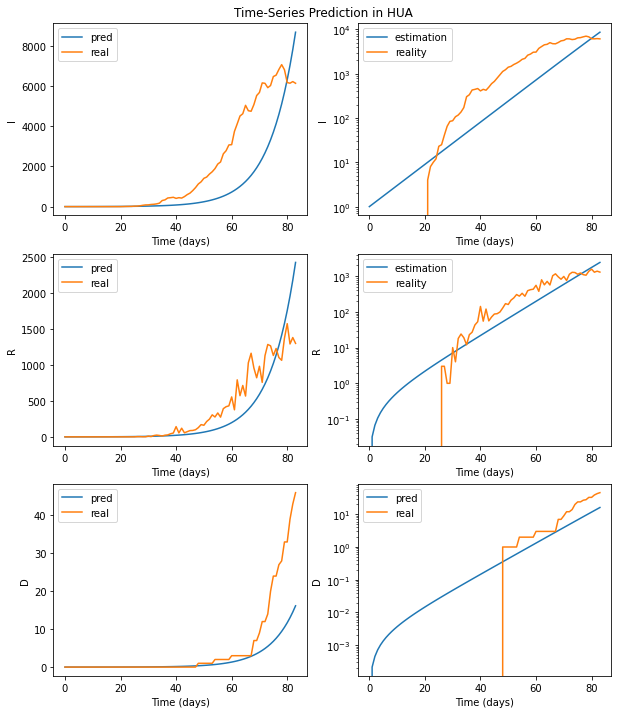

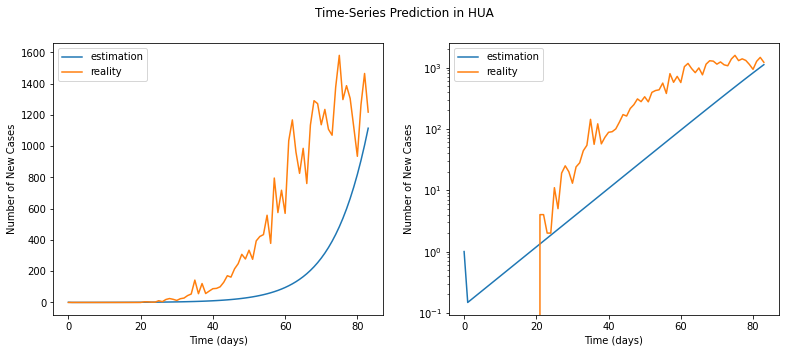

===== City: TTT =====
population = 212959
Best parameters: b = 0.12999999999999998, g = 0.03, u = 0.0002
Minimal MSE = 715.5202299436654


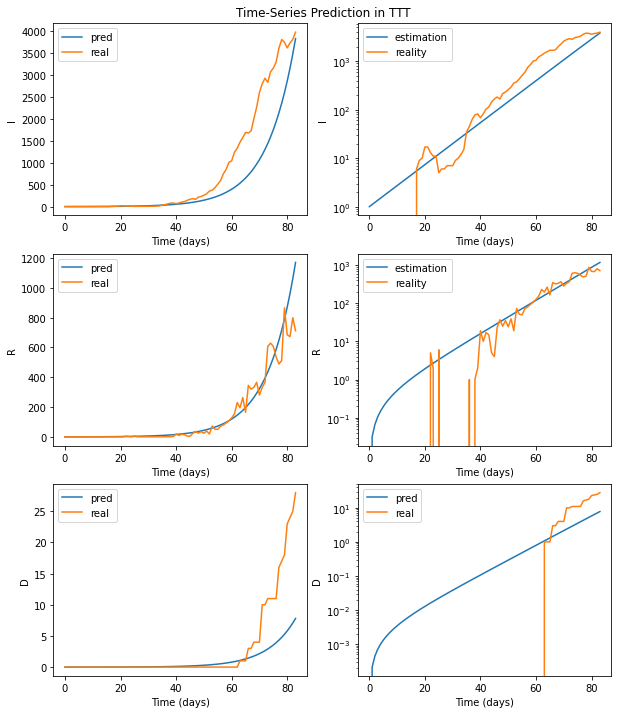

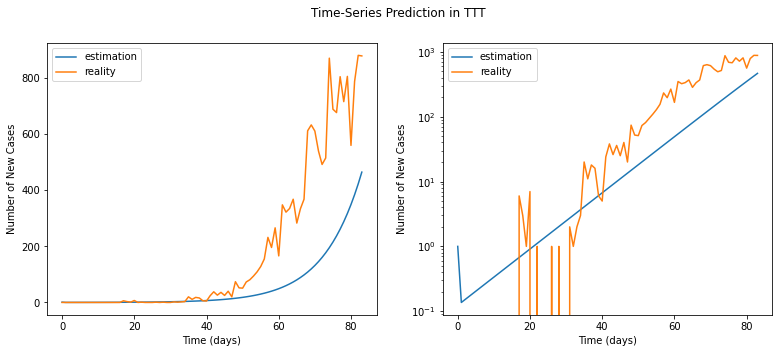

===== City: PEN =====
population = 106216
Best parameters: b = 0.09999999999999999, g = 0.02, u = 0.0002
Minimal MSE = 164.76993322183395


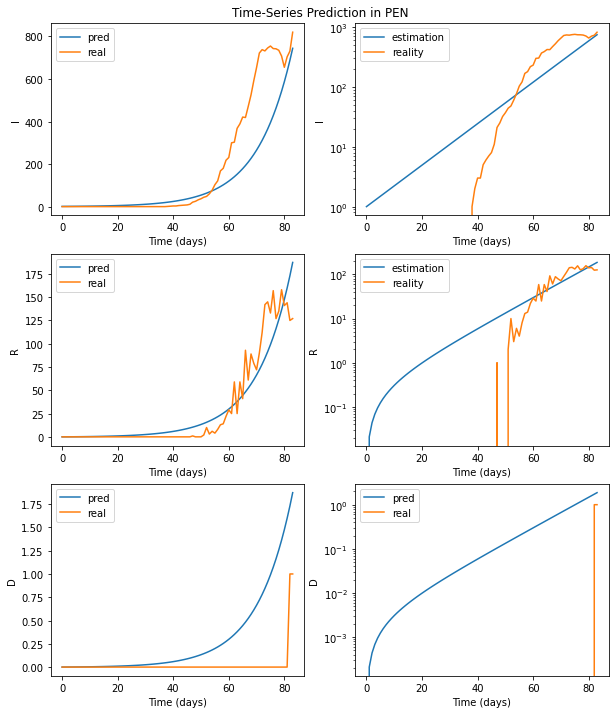

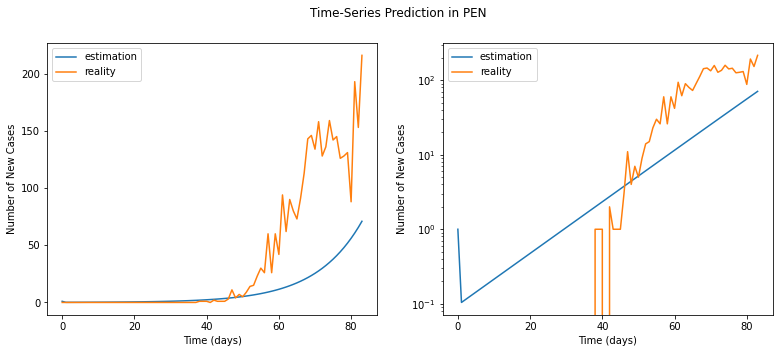

===== City: KIN =====
population = 140510
Best parameters: b = 0.09999999999999999, g = 0.02, u = 0.0002
Minimal MSE = 127.59987696911138


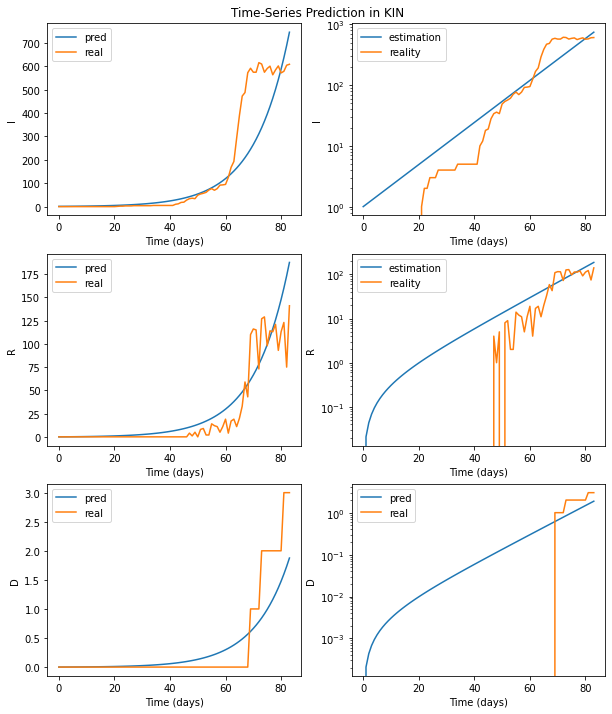

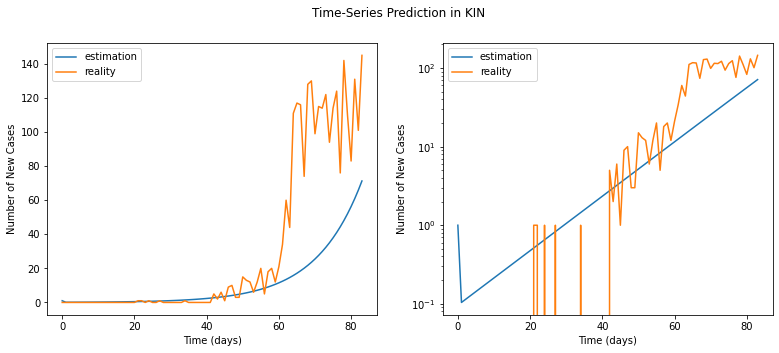

===== City: LIE =====
population = 13752
Best parameters: b = 0.08, g = 0.01, u = 0.0002
Minimal MSE = 33.855280166970786


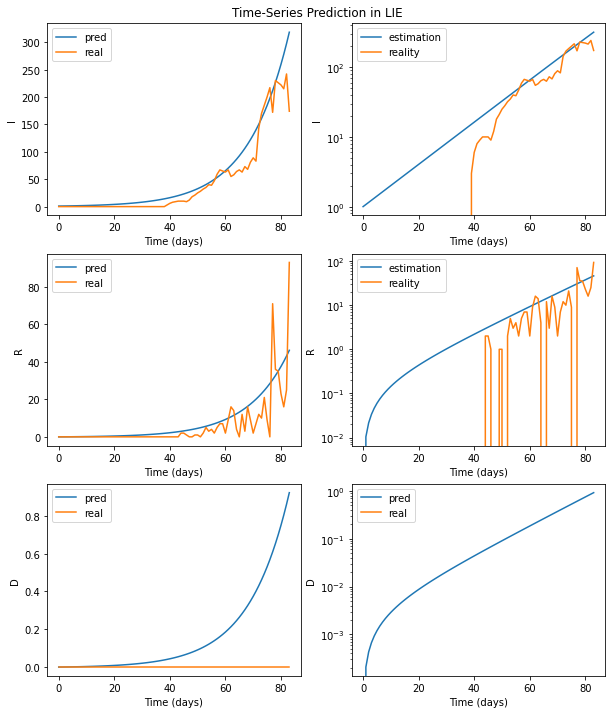

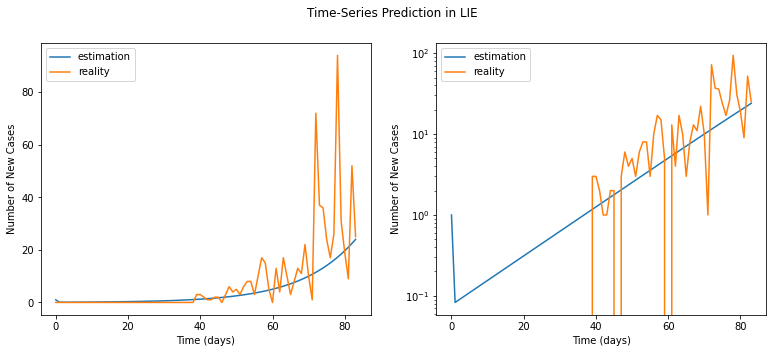

===== City: TW =====
population = 23215015
Best parameters: b = 0.19999999999999996, g = 0.04, u = 0.0002
Minimal MSE = 159680.00344842832


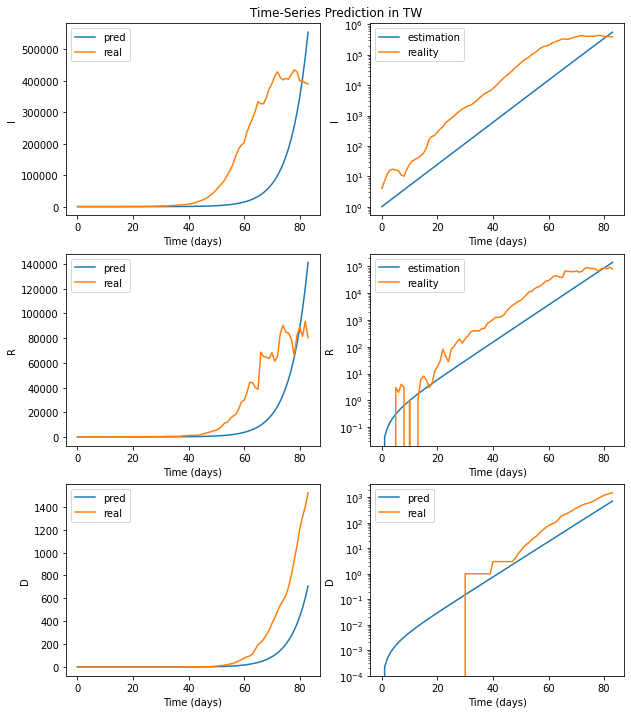

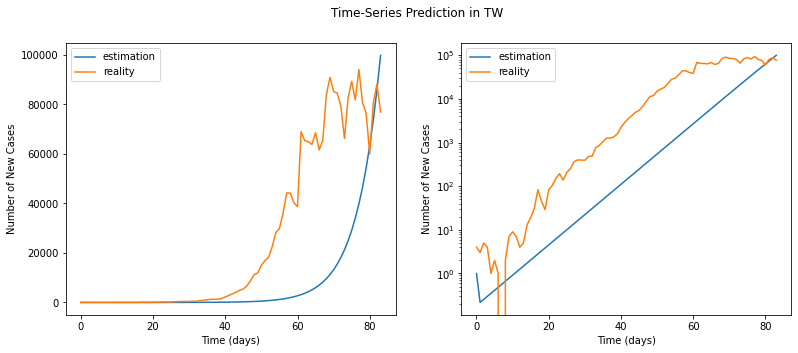

In [180]:
# TODO: read from file: diagnosed, population
populationDf = pd.read_csv('populationAdj.csv')
confirmedDf = pd.read_csv('timeline_diagnosed.csv')
deadDf = pd.read_csv('timeline_death.csv')

confirmedDf['date'] = pd.to_datetime(confirmedDf['date'], format='%Y-%m-%d')
confirmedDf.set_index('date', inplace=True)

deadDf['date'] = pd.to_datetime(deadDf['date'], format='%Y-%m-%d')
deadDf.set_index('date', inplace=True)

city_code = ["KEE", "NWT", "TPE", "TAO", "HSZ", "HSQ", "MIA", "TXG", "CHA", "NAN", "YUN", "CYQ", "CYI", "TNN", "KHH", "PIF", "ILA", "HUA", "TTT", "PEN", "KIN", "LIE", "TW"]
# city_code = ["NWT", "TPE", "TXG", "KHH", "TTT", "PEN", "TW"]

for city in city_code:
    # get new_infected_data for each city
    population, new_infected_data, timelineI, timelineR, timelineD = getCityData(populationDf, confirmedDf, deadDf, city)

    print(f"===== City: {city} =====")
    print(f"population = {population}")
    # print(f"I: {timelineI}")
    # print(f"R: {timelineR}")
    # print(f"D: {timelineD}")
    b, g, u = estiCity(population, timelineI, timelineR, timelineD, city)
    plotEsti(timelineI, timelineR, timelineD, population, b, g, u, city)
    plotNewCases(new_infected_data, population, b, g, u, city)


## Source Reference
* https://colab.research.google.com/github/alsnhll/SEIR_COVID19/blob/master/SEIR_COVID19.ipynb